In [1]:
!pip install -r requirements.txt
# import sys
# sys.path.append('..')

In [3]:
import portpy.photon as pp
from low_dim_rt import LowDimRT
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
# %run ex_wavelet.py

In [2]:
# specify the patient data location
# you first need to download the patient database from the link provided in the PortPy GitHub page
data_dir = r'.\data'
# pick a patient from the existing patient list to get detailed info about the patient data (e.g., beams_dict, structures, ...)
patient_id = 'Lung_Patient_2'
# create my_plan object for the planner beams_dict and select among the beams which are 30 degrees apart
# for the customized beams_dict, you can pass the argument beam_ids
my_plan = pp.Plan(patient_id, data_dir)


Creating BEV..
Loading sparse influence matrix...
Done


In [3]:
# Let us create rinds for creating reasonable dose fall off for the plan
rind_max_dose = np.array([1.1, 1.05, 0.9, 0.85, 0.75]) * my_plan.get_prescription()
rind_params = [{'rind_name': 'RIND_0', 'ref_structure': 'PTV', 'margin_start_mm': 0, 'margin_end_mm': 5,
                'max_dose_gy': rind_max_dose[0]},
               {'rind_name': 'RIND_1', 'ref_structure': 'PTV', 'margin_start_mm': 5, 'margin_end_mm': 10,
                'max_dose_gy': rind_max_dose[1]},
               {'rind_name': 'RIND_2', 'ref_structure': 'PTV', 'margin_start_mm': 10, 'margin_end_mm': 30,
                'max_dose_gy': rind_max_dose[2]},
               {'rind_name': 'RIND_3', 'ref_structure': 'PTV', 'margin_start_mm': 30, 'margin_end_mm': 60,
                'max_dose_gy': rind_max_dose[3]},
               {'rind_name': 'RIND_4', 'ref_structure': 'PTV', 'margin_start_mm': 60, 'margin_end_mm': 'inf',
                'max_dose_gy': rind_max_dose[4]}]
my_plan.add_rinds(rind_params=rind_params)

creating rinds..
rinds created!!


In [4]:
# With no quadratic smoothness
prob = pp.CvxPyProb(my_plan, opt_params={'smoothness_weight': 0})
prob.solve(solver='MOSEK', verbose=False)
sol_no_quad_no_wav = prob.get_sol()

Objective Start
Objective done
Constraints Start
Constraints done


In [5]:
# creating the wavelet incomplete basis representing a low dimensional subspace for dimension reduction
wavelet_basis = LowDimRT.get_low_dim_basis(my_plan.inf_matrix, 'wavelet')
# Smoothness Constraint
y = cp.Variable(wavelet_basis.shape[1])
prob.constraints += [wavelet_basis @ y == prob.x]
prob.solve(solver='MOSEK', verbose=False)
sol_no_quad_with_wav = prob.get_sol()

In [6]:
# create cvxpy problem using the clinical criteria
prob = pp.CvxPyProb(my_plan, opt_params={'smoothness_weight': 10})
# run IMRT fluence map optimization using a low dimensional subspace for fluence map compression
prob.solve(solver='MOSEK', verbose=False)
sol_quad_no_wav = prob.get_sol()

Objective Start
Objective done
Constraints Start
Constraints done


In [7]:
# Smoothness Constraint
y = cp.Variable(wavelet_basis.shape[1])
prob.constraints += [wavelet_basis @ y == prob.x]
prob.solve(solver='MOSEK', verbose=False)
sol_quad_with_wav = prob.get_sol()

In [35]:
# pp.save_plan(my_plan, plan_name='my_plan', path=r'C:\temp')
# pp.save_optimal_sol(sol_no_quad_no_wav, sol_name='sol_no_quad_no_wav', path=r'C:\temp')
# pp.save_optimal_sol(sol_no_quad_with_wav, sol_name='sol_no_quad_with_wav', path=r'C:\temp')
# pp.save_optimal_sol(sol_quad_no_wav, sol_name='sol_quad_no_wav', path=r'C:\temp')
# pp.save_optimal_sol(sol_quad_with_wav, sol_name='sol_quad_with_wav', path=r'C:\temp')

In [5]:
# my_plan = pp.load_plan(plan_name='my_plan', path=r'C:\temp')
# sol_no_quad_no_wav = pp.load_optimal_sol(sol_name='sol_no_quad_no_wav', path=r'C:\temp')
# sol_no_quad_with_wav = pp.load_optimal_sol(sol_name='sol_no_quad_with_wav', path=r'C:\temp')
# sol_quad_no_wav = pp.load_optimal_sol(sol_name='sol_quad_no_wav', path=r'C:\temp')
# sol_quad_with_wav = pp.load_optimal_sol(sol_name='sol_quad_with_wav', path=r'C:\temp')

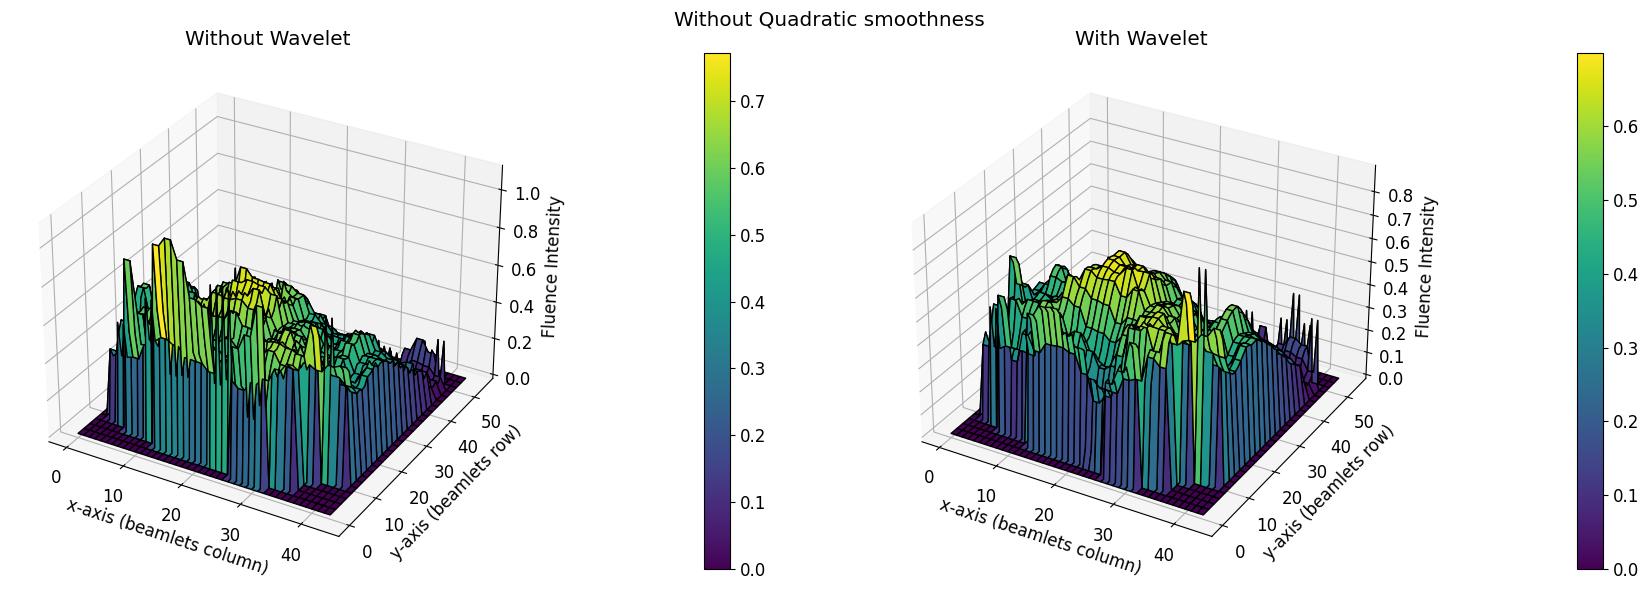

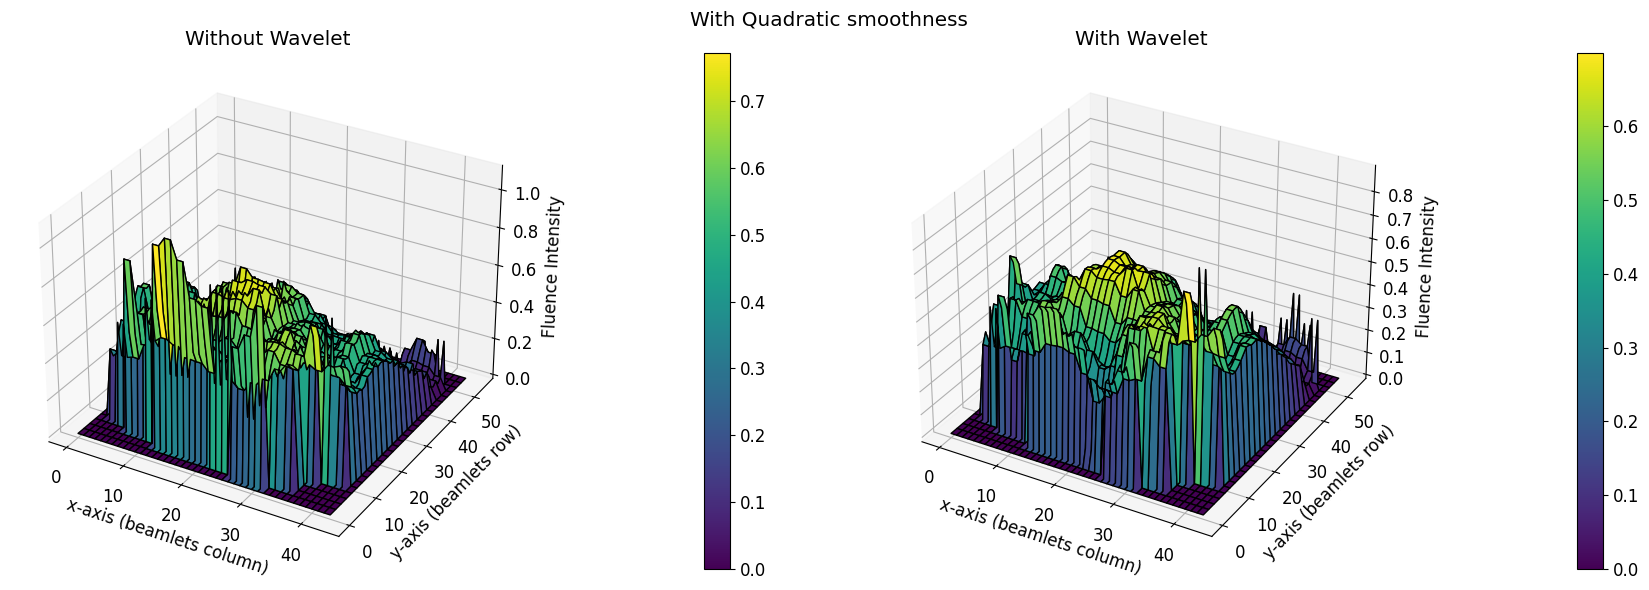

In [14]:
# plot fluence 3D and 2D
fig, ax = plt.subplots(1, 2, figsize=(18,6), subplot_kw={'projection': '3d'})
fig.suptitle('Without Quadratic smoothness')
pp.Visualize.plot_fluence_3d(sol=sol_no_quad_no_wav, beam_id=37, ax=ax[0], title='Without Wavelet')
pp.Visualize.plot_fluence_3d(sol=sol_no_quad_with_wav, beam_id=37, ax=ax[1], title='With Wavelet')

fig, ax = plt.subplots(1, 2, figsize=(18,6), subplot_kw={'projection': '3d'})
fig.suptitle('With Quadratic smoothness')
pp.Visualize.plot_fluence_3d(sol=sol_quad_no_wav, beam_id=37, ax=ax[0], title='Without Wavelet')
pp.Visualize.plot_fluence_3d(sol=sol_quad_with_wav, beam_id=37, ax=ax[1], title='With Wavelet')

plt.show()

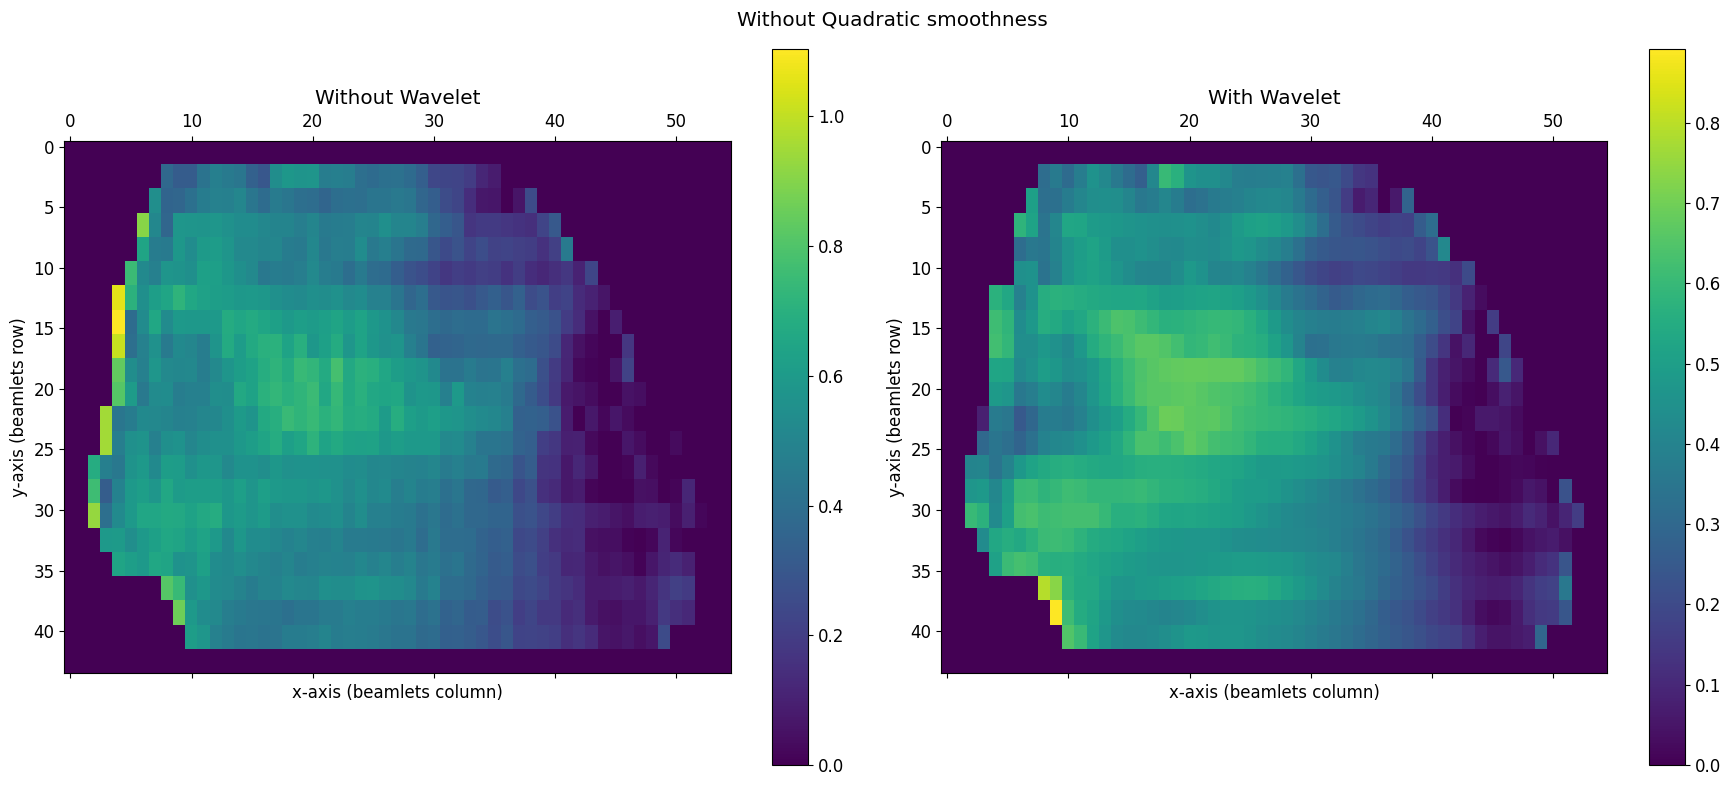

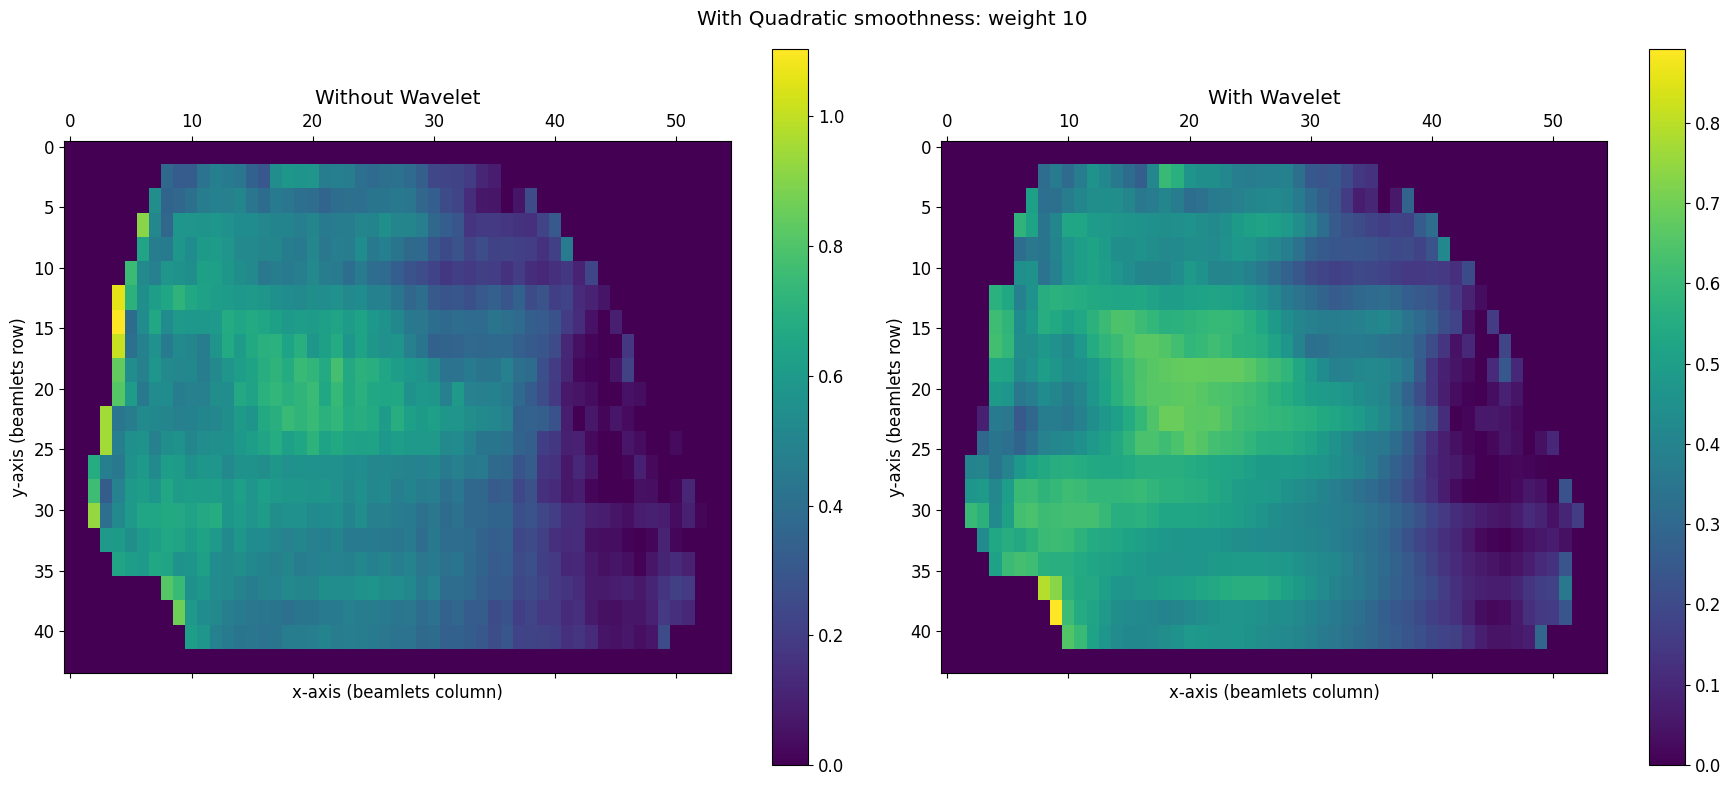

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Without Quadratic smoothness')
pp.Visualize.plot_fluence_2d(sol=sol_no_quad_no_wav, beam_id=37, ax=ax[0], title='Without Wavelet')
pp.Visualize.plot_fluence_2d(sol=sol_no_quad_with_wav, beam_id=37, ax=ax[1], title='With Wavelet')
plt.show()
print('\n\n')
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('With Quadratic smoothness: weight 10')
pp.Visualize.plot_fluence_2d(sol=sol_quad_no_wav, beam_id=37, ax=ax[0], title='Without Wavelet')
pp.Visualize.plot_fluence_2d(sol=sol_quad_with_wav, beam_id=37, ax=ax[1], title='With Wavelet')
plt.show()

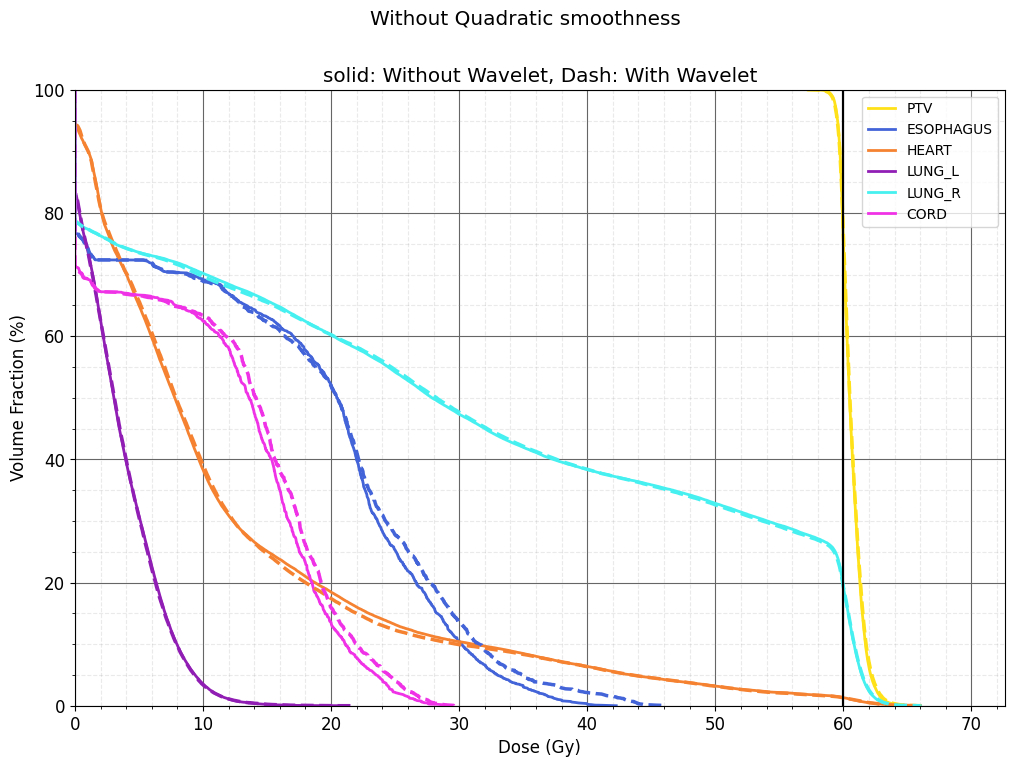

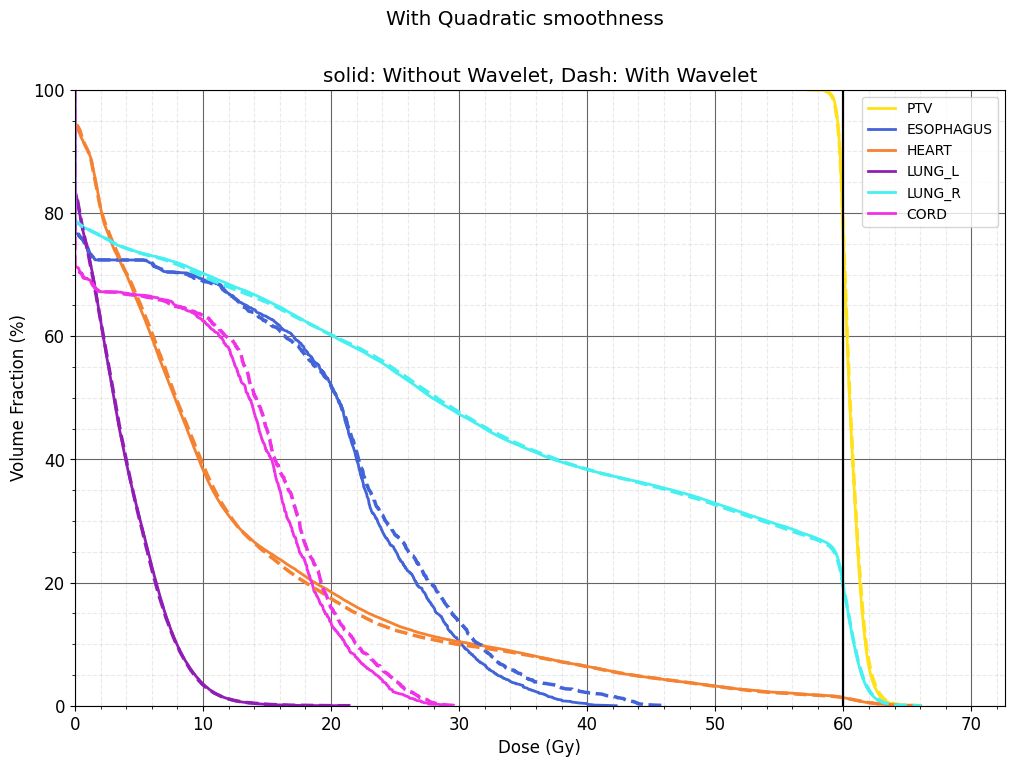

In [10]:
# plot DVH for the structures in the given list. Default dose_1d is in Gy and volume is in relative scale(%).
structs = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD', 'LUNG_L', 'LUNG_R']
fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualize.plot_dvh(my_plan, sol=sol_no_quad_no_wav, structs=structs, style='solid', ax=ax)
ax = pp.Visualize.plot_dvh(my_plan, sol=sol_no_quad_with_wav, structs=structs, style='dashed', ax=ax)
fig.suptitle('Without Quadratic smoothness')
ax.set_title('solid: Without Wavelet, Dash: With Wavelet')
plt.show()
print('\n\n')

fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualize.plot_dvh(my_plan, sol=sol_quad_no_wav, structs=structs, style='solid', ax=ax)
ax = pp.Visualize.plot_dvh(my_plan, sol=sol_quad_with_wav, structs=structs, style='dashed', ax=ax)
fig.suptitle('With Quadratic smoothness')
ax.set_title('solid: Without Wavelet, Dash: With Wavelet')
plt.show()


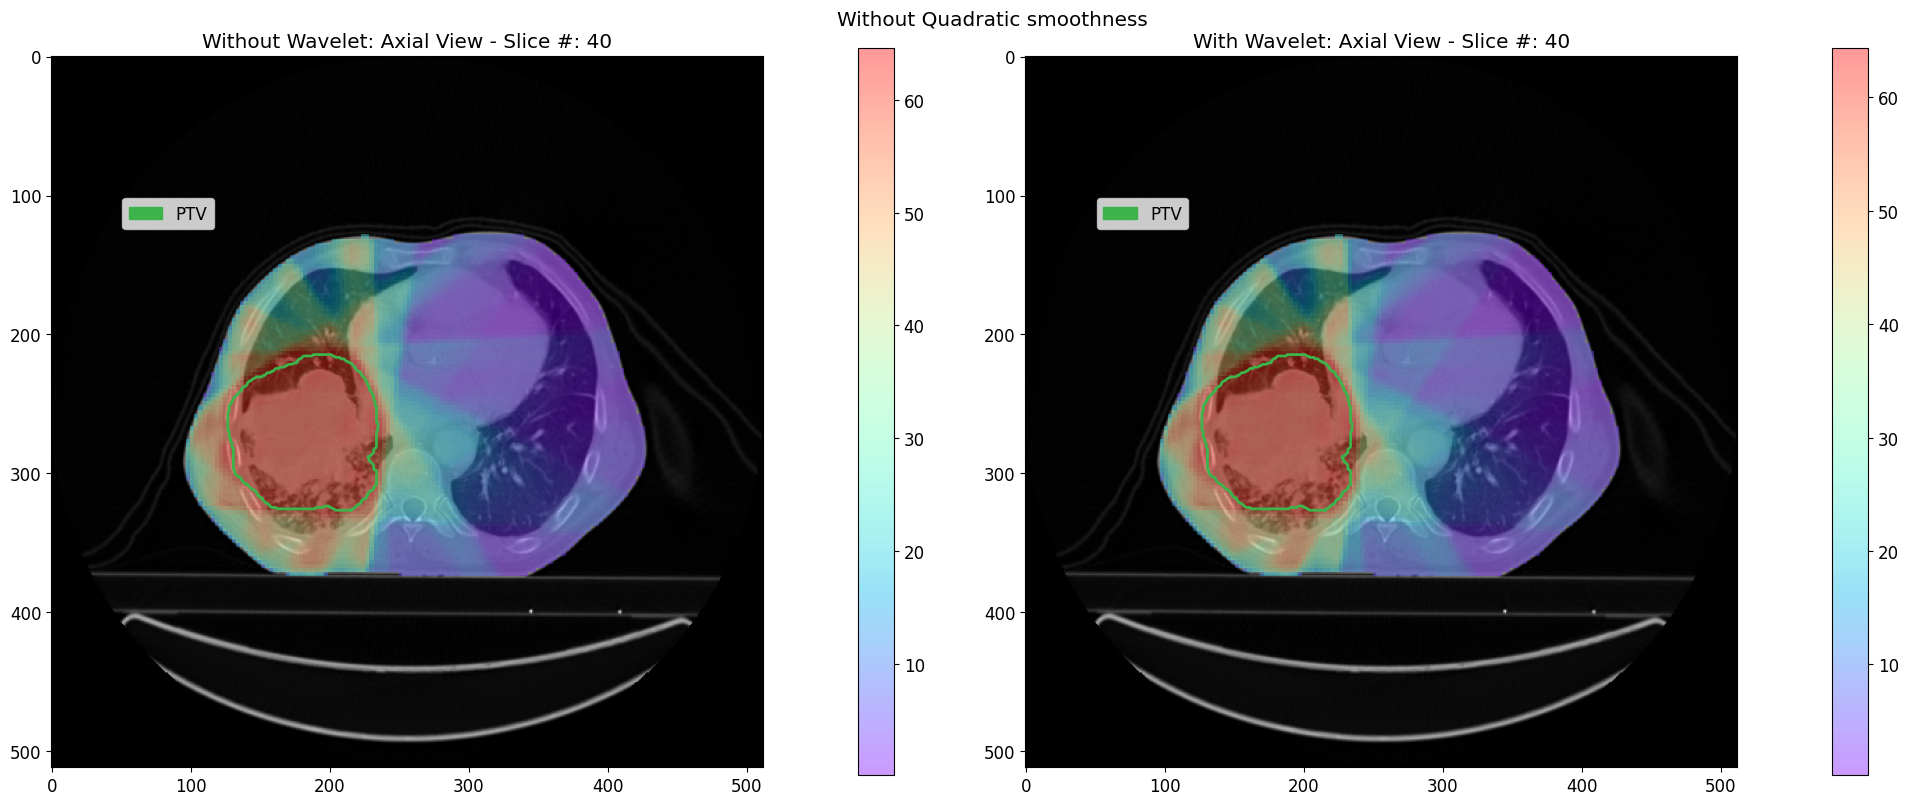

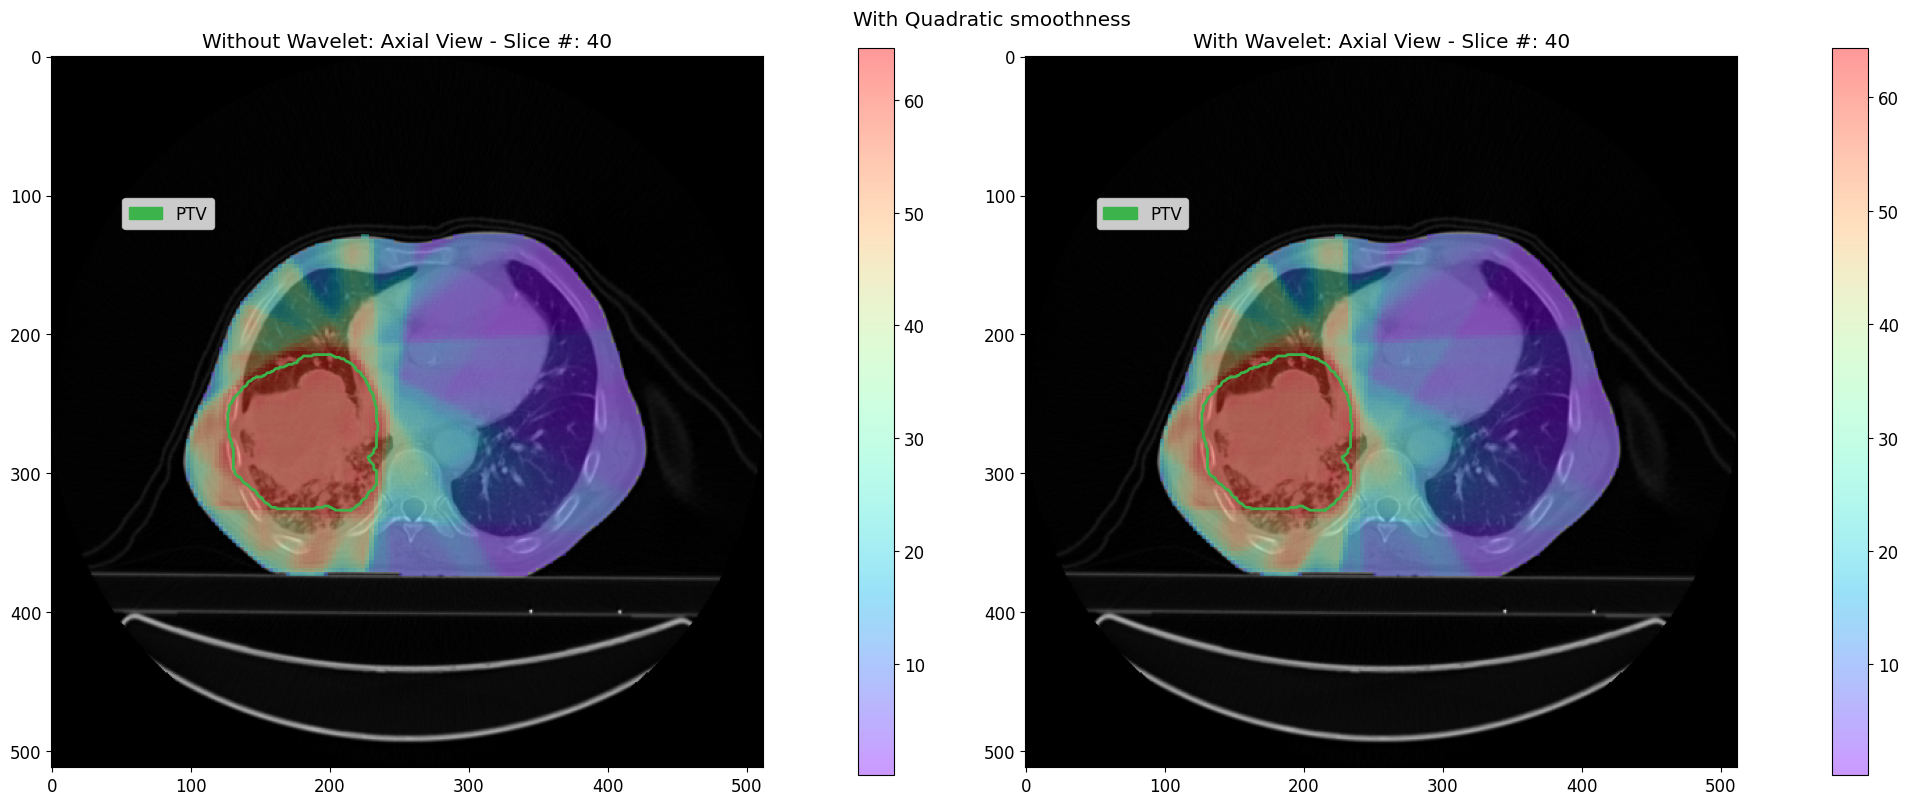

In [18]:
# plot 2d axial slice for the given solution and display the structures contours on the slice
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Without Quadratic smoothness')
pp.Visualize.plot_2d_dose(my_plan, sol=sol_no_quad_no_wav, slice_num=40, structs=['PTV'], ax=ax[0], title='Without Wavelet')
pp.Visualize.plot_2d_dose(my_plan, sol=sol_no_quad_with_wav, slice_num=40, structs=['PTV'], ax=ax[1], title='With Wavelet')
plt.show()
print('\n\n')

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('With Quadratic smoothness')
pp.Visualize.plot_2d_dose(my_plan, sol=sol_quad_no_wav, slice_num=40, structs=['PTV'], ax=ax[0], title='Without Wavelet')
pp.Visualize.plot_2d_dose(my_plan, sol=sol_quad_with_wav, slice_num=40, structs=['PTV'], ax=ax[1], title='With Wavelet')
plt.show()

In [13]:
# visualize plan metrics based upon clinical criteria
pp.Visualize.plan_metrics(my_plan, sol=[sol_no_quad_no_wav, sol_no_quad_with_wav, sol_quad_no_wav, sol_quad_with_wav])

,name,parameters,constraints,Plan Value 0,Plan Value 1,Plan Value 2,Plan Value 3
0,max_dose,{'structure_name': 'GTV'},"{'limit_dose_gy': 69, 'goal_dose_gy': 66}",64.546,64.700,64.546,64.700
1,max_dose,{'structure_name': 'PTV'},"{'limit_dose_gy': 69, 'goal_dose_gy': 66}",66.000,66.000,66.000,66.000
2,max_dose,{'structure_name': 'ESOPHAGUS'},{'limit_dose_gy': 66},42.256,46.177,42.256,46.177
3,mean_dose,{'structure_name': 'ESOPHAGUS'},"{'limit_dose_gy': 34, 'goal_dose_gy': 21}",16.732,17.206,16.732,17.206
4,dose_volume_V,"{'structure_name': 'ESOPHAGUS', 'dose_gy': 60}",{'limit_volume_perc': 17},0.000,0.000,0.000,0.000
5,max_dose,{'structure_name': 'HEART'},{'limit_dose_gy': 66},66.000,66.000,66.000,66.000
6,mean_dose,{'structure_name': 'HEART'},"{'limit_dose_gy': 27, 'goal_dose_gy': 20}",12.190,12.104,12.190,12.104
7,dose_volume_V,"{'structure_name': 'HEART', 'dose_gy': 30}",{'limit_volume_perc': 50},10.401,9.918,10.401,9.918
8,dose_volume_V,"{'structure_name': 'HEART', 'dose_gy': 30}",{'goal_volume_perc': 48},10.401,9.918,10.401,9.918
9,max_dose,{'structure_name': 'LUNG_L'},{'limit_dose_gy': 66},21.178,21.802,21.178,21.802
